In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import os
print(os.getpid())
%cd ../../

colors_ = ["blue", "red", "green", "gray", "black"]

import pylib.mix as mix
import pylib.qucf_read as qucf_r
import pylib.measurement as mse

9314
/media/work/docs/codes/QuCF/scripts-py


In [2]:
path_qucf_ = "../QuCF/simulations/MI/Inv"
name_qucf_pr_   = "MI"
name_qucf_file_ = name_qucf_pr_ + "_OUTPUT.hdf5"

path_save_plots_ = "./tools/QSVT-angles/inversion/saved-plots/"

for i in range(100):
    plt.close()

nx	 7
kappa	 100000.0


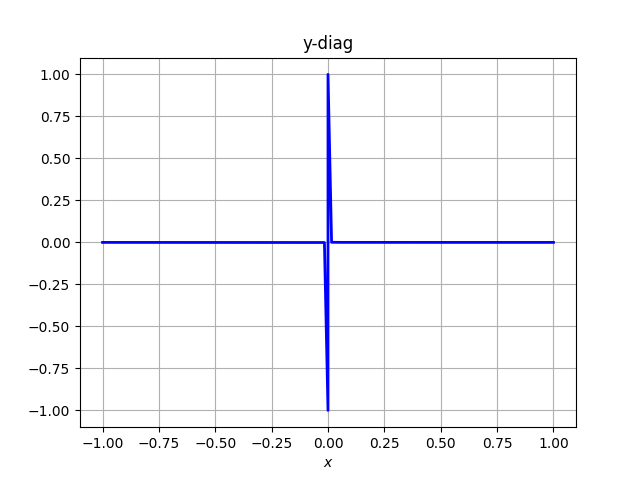

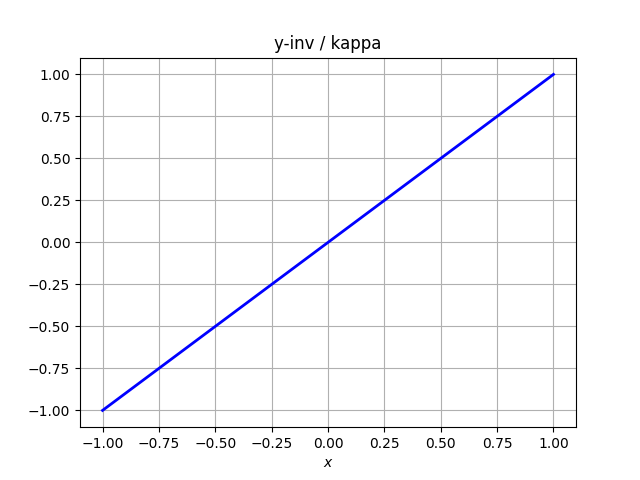

In [44]:
# ------------------------------------------------------------------
# --- Create a reference matrix ---
# ------------------------------------------------------------------
def prepare_ref():
    # --- Print initial parameters for BE ---
    print("nx\t {:d}".format(nx_))
    print("kappa\t {:0.1f}".format(kappa_goal_))

    # --- x grid ---
    Nx_ = 1 << nx_
    x_grid_1 = np.linspace(-1.0, -1.0/kappa_goal_, Nx_//2)
    x_grid_2 = np.linspace(1.0/kappa_goal_, 1.0, Nx_//2)
    x_ = np.concatenate((x_grid_1, x_grid_2))

    # --- function to inverse ---
    y_diag_ = ( 1. - np.exp(-(5*kappa_goal_*x_)**2) ) / x_
    y_diag_ /= kappa_goal_

    # --- matrix whose singular values encode the function ---
    A_ = np.diag(y_diag_)

    # --- reference inverse function ---
    y_inv_ref_ = 1. / y_diag_
    y_inv_ref_ /= kappa_goal_

    # --- Plotting the intial function ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_, y_diag_, color='b', linewidth = 2, linestyle='-')
    plt.xlabel('$x$')
    plt.title("y-diag")
    plt.grid(True)
    plt.show()

    # --- Plotting the initial function ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_, y_inv_ref_, color='b', linewidth = 2, linestyle='-')
    plt.xlabel('$x$')
    plt.title("y-inv / kappa")
    plt.grid(True)
    plt.show()

    return x_, Nx_, y_diag_, A_, y_inv_ref_
# --------------------------------------------------------------
kappa_goal_ = 1e5
nx_ = 7
x_, Nx_, y_diag_, A_, y_inv_ref_ = prepare_ref()

In [45]:
# ----------------------------------------------------------
# --- Compute the condition number ---
# ----------------------------------------------------------
from numpy import linalg as LA

evals, evecs = LA.eig(A_)
kappa_ = np.max(np.abs(evals)) / np.min(np.abs(evals))
print("nx: \t{:d}".format(nx_))
print("cond. number: {:0.1e}".format(kappa_))

nx: 	7
cond. number: 1.0e+05


Reading the file ../QuCF/simulations/MI/Inv/results//MI_k1e5_OUTPUT.hdf5...
Name of the simulation is MI
Simulation has been performed  07-22-2024 15:28:13

QSVT kappa: 1.0e+05

max. relative err: 1.270e-04


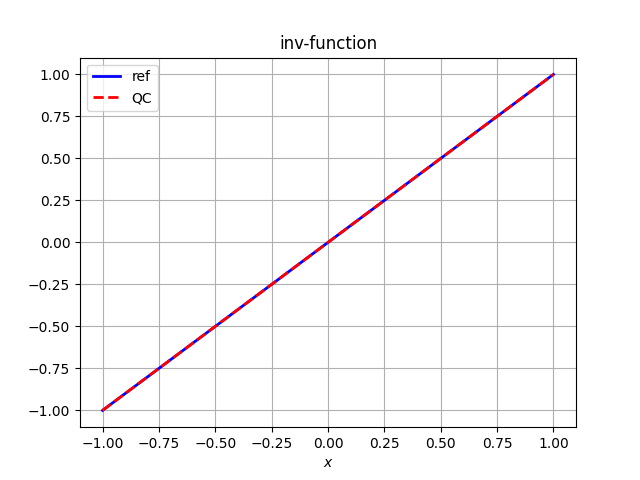

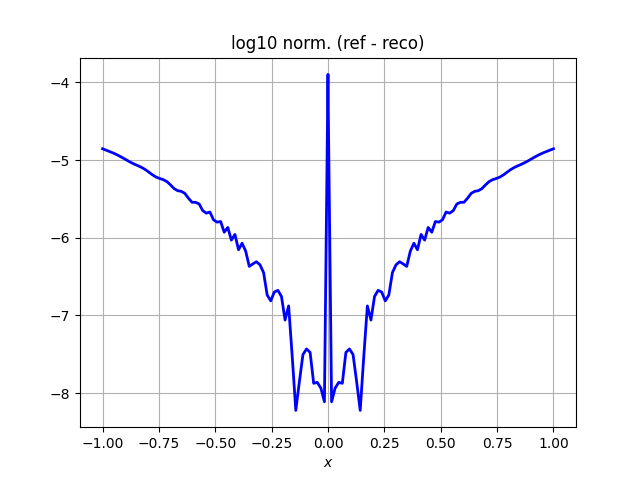

In [46]:
# -------------------------------------------------
# --- Matrix inversion ---
# -------------------------------------------------
mix.reload_module(mse)
def compare_with_qucf(flag_adv, flag_save):
    # --- Reading QC data ---
    km, ke = mix.get_order_base10(kappa_goal_)
    str_k = "{:0.0f}e{:d}".format(km, ke)
    pr_name = "MI_k{:s}".format(str_k)
    if flag_adv:
        pr_name += "_ADV"
        
    # pr_name = name_qucf_pr_

    om = mse.MeasOracle__(True)
    om.path_  = path_qucf_ + "/results/"
    om.pname_ = pr_name
    om.open()

    # --- QSVT parameter ---
    om.read_qsvt()
    kappa_qc = om.dd_["qsvt_mi"]["par"]
    if np.abs(kappa_qc - kappa_goal_) > 1e-4:
        print()
        print("<<< ERROR: a wrong QSVT parameter.>>>")
        print()
    print()
    print("QSVT kappa: {:0.1e}".format(kappa_qc))

    # --- QuCF data ---
    om.set_zero_ancillae_work_states(0)
    qc_data_all = om.get_var_x({}, "rs")

    y_inv_qc_ = qc_data_all.imag  # correct global phase;

    y_inv_qc_ *= 2**(nx_/2.) / om.dd_["qsvt_mi"]["rescaling_factor"]
    if y_inv_qc_[0] > 0:
        y_inv_qc_ *= -1 # correct global phase;

    # --- Relative error ---
    norm_diff = y_inv_ref_ - y_inv_qc_
    max_rel_err = np.max(np.abs(norm_diff))
    log_norm_diff = np.log10(np.abs(norm_diff))
    print()
    print("max. relative err: {:0.3e}".format(max_rel_err))

    # --- Plotting: comparison ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(
        x_, y_inv_ref_, 
        color='b', linewidth = 2, linestyle='-',  
        label = "ref"
    )
    ax.plot(
        x_, y_inv_qc_,
        color='r', linewidth = 2, linestyle='--',  
        label = "QC"
    )
    plt.xlabel('$x$')
    plt.title("inv-function")
    ax.legend()
    plt.grid(True)
    plt.show()

    # --- Plotting: error ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_, log_norm_diff, color='b', linewidth = 2, linestyle='-')
    plt.xlabel('$x$')
    plt.title("log10 norm. (ref - reco)")
    plt.grid(True)
    plt.show()

    if flag_save:
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_Dir_ref_k{:s}.dat".format(str_k),
            x_, y_inv_ref_
        )
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_Dir_reco_k{:s}.dat".format(str_k),
            x_, y_inv_qc_
        )
        mix.save_dat_plot_1d_file(
            path_save_plots_ + "/QSVT_Dir_err_x_k{:s}.dat".format(str_k), 
            x_, log_norm_diff
        )

    return
# ----------------------------------------------------------
compare_with_qucf(
    flag_adv = False,
    flag_save = False
)

In [47]:
# ----------------------------------------------------
# --- Scans ---
# ----------------------------------------------------
def save_max_rel_error():
    k__array  = [      1e3,       5e3,       1e4,       5e4,       1e5,       1e6]
    err_array = [2.331e-04, 5.653e-04, 5.891e-04, 1.356e-04, 1.270e-04, 1.316e-05]
    mix.save_dat_plot_1d_file(
        path_save_plots_ + "/QSVT_Dir_err_kappa.dat", 
        k__array, np.log10(err_array)
    )
    return
# ----------------------------------------------------
save_max_rel_error()

write data to a file: ./tools/QSVT-angles/inversion/saved-plots//QSVT_Dir_err_kappa.dat


Reading the matrix from: MI_OUTPUT.hdf5
from the path: ../QuCF/simulations/MI/Inv
date of the simulation:  07-22-2024 10:47:54
matrix name:  U_BE
N = 128


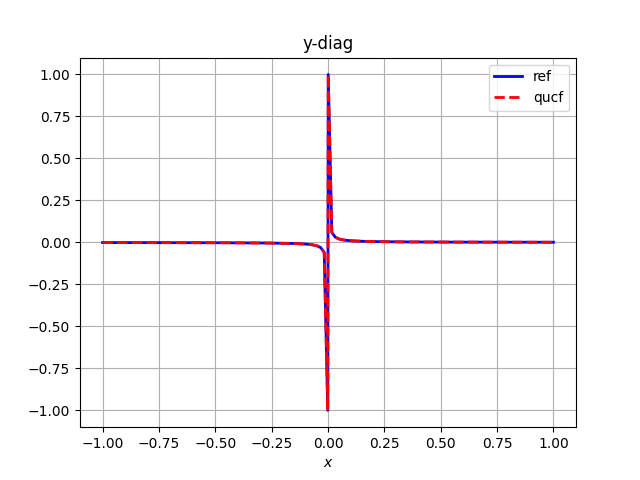

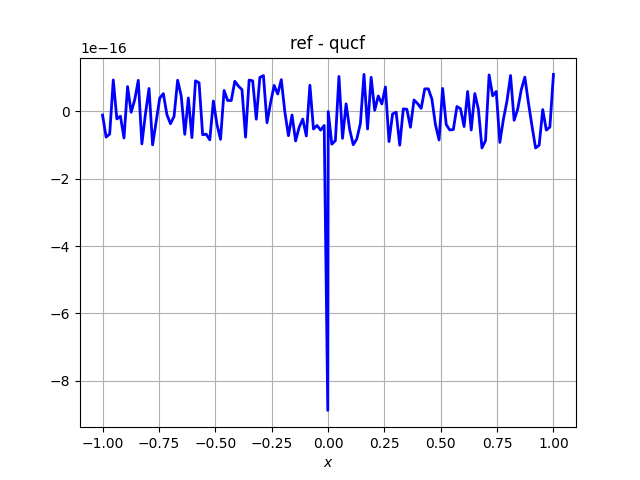

In [6]:
# --------------------------------------------------------
# --- Recheck the BE oracle ---
# --------------------------------------------------------
mix.reload_module(qucf_r)
def recheck_BE():
    dd = qucf_r.read_matrix_sparse(path_qucf_, name_qucf_file_)
    A_qucf = dd["A"].form_dense_matrix() 
    y_qucf, _ = mix.get_diag(A_qucf.real, i_shift = 0)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_, y_diag_, color='b', linewidth = 2, linestyle='-',  label = "ref")
    ax.plot(x_, y_qucf, color='r', linewidth = 2, linestyle='--', label = "qucf")
    plt.xlabel('$x$')
    plt.title("y-diag")
    plt.grid(True)
    plt.legend()
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_, y_diag_ - y_qucf, color='b', linewidth = 2, linestyle='-')
    plt.xlabel('$x$')
    plt.title("ref - qucf")
    plt.grid(True)
    plt.show()
    return
# ----------------------------------------------------------------------
recheck_BE()